In [1]:
import pandas as pd
import json

with open("option_columns.json","r") as f:
    option_columns = json.load(f)

df = pd.read_csv("dataset_encoded_all_size.csv", dtype={k:"int8" for k in option_columns})
df.query("cid >= 30000", inplace=True)
df.fillna(-1, inplace=True)
df.query("vmlinux >= 0", inplace=True)

In [2]:
df[:5]

,X86_LOCAL_APIC,OPENVSWITCH,TEXTSEARCH_FSM,LOCKDEP_SUPPORT,GENERIC_CLOCKEVENTS_MIN_ADJUST,NETFILTER_XT_MATCH_TCPMSS,MPLS,NFC_HCI,STACKTRACE_SUPPORT,GENERIC_CMOS_UPDATE,...,XZ-bzImage,XZ-vmlinux,XZ,LZO-bzImage,LZO-vmlinux,LZO,LZ4-bzImage,LZ4-vmlinux,LZ4,cid
14758,1,0,0,1,1,0,1,0,1,1,...,5178320.0,7264848,4980068,8922064.0,11008072,8734199,9839568.0,11925896,9638560,30000
14759,1,0,0,1,1,0,0,0,1,1,...,2840016.0,4924448,2695928,4519376.0,6603288,4385061,4838864.0,6923096,4693085,30001
14760,1,0,0,1,1,0,0,0,1,1,...,8496592.0,10581024,8351248,12391888.0,14475800,12256864,13362640.0,15446872,13214970,30002
14761,1,0,0,1,1,0,0,0,1,1,...,6304720.0,8390008,6156724,8782800.0,10867576,8647251,9302992.0,11388080,9155423,30003
14762,1,0,0,1,1,0,0,1,1,1,...,12321744.0,14407032,12176312,17933264.0,20018040,17796721,19346384.0,21431472,19197696,30004


In [3]:
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

In [12]:
#learning a model by using linear regression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import ElasticNet

def run_regressorML(reg, test_size, size_target="vmlinux"):
    assert(size_target in size_methods)
    x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=["cid"]).drop(columns=size_methods), df[size_target], test_size=test_size, random_state=42)  
    x_train, y_train = np.array(x_train.values), np.array(y_train.values)
    reg.fit(x_train, y_train)
    
    r_sq = reg.score(x_train, y_train)
    print('coefficient of determination:', r_sq)
    print('intercept:', reg.intercept_)
    print('slope:', reg.coef_)

    #validation
    y_pred = reg.predict(x_test)
    #y_pred = reg.intercept_ + np.sum(reg.coef_ * x_test.values, axis=1)
    dfErrors = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, "error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
    return dfErrors["% error"].describe()

In [13]:
def ft_importances(reg):
    col = df.drop(columns=["cid"]).drop(columns=size_methods).columns
    
    importanceSeries = pd.Series(reg.coef_, index=col.values)
    return importanceSeries[importanceSeries != 0].abs().sort_values(ascending = False)
    #importanceSeries.map(lambda x : x[0]).abs().sort_values(ascending = False)


In [14]:
#learning a model by using multiple linear regression
reg_model = LinearRegression()
res_model = run_regressorML(reg_model, test_size=0.9, size_target="vmlinux")
print(res_model)

order_lr = ft_importances(reg_model)
order_lr.to_csv("feature_importanceLR.csv", header=True)
order_lr

coefficient of determination: 0.9817247764142544
intercept: -5.1278869467217786e+17
slope: [ 3.58834911e+17 -9.95254859e+06  3.44828557e+17 ... -7.14410400e+06
  5.18552800e+06 -1.12688180e+07]


GENERIC_CLOCKEVENTS_MIN_ADJUST         4.797692e+17
LOCKDEP_SUPPORT                        4.682900e+17
GENERIC_CPU_AUTOPROBE                  4.318190e+17
X86_LOCAL_APIC                         3.588349e+17
TEXTSEARCH_BM                          3.448286e+17
TEXTSEARCH_FSM                         3.448286e+17
GENERIC_IOMAP                          3.321822e+17
GENERIC_IRQ_SHOW                       3.295392e+17
STACKTRACE_SUPPORT                     3.288167e+17
GENERIC_SMP_IDLE_THREAD                2.992894e+17
GENERIC_IRQ_MIGRATION                  2.838670e+17
NEED_DMA_MAP_STATE                     2.751407e+17
GENERIC_FIND_FIRST_BIT                 2.566994e+17
OSF4_COMPAT                            1.836140e+17
GENERIC_EARLY_IOREMAP                  1.724613e+17
ORION_WATCHDOG                         1.620852e+17
NEED_SG_DMA_LENGTH                     1.328073e+17
GENERIC_STRNLEN_USER                   1.281983e+17
WANT_COMPAT_NETLINK_MESSAGES           1.209486e+17
X86_SPEEDSTE

In [32]:
#learning a model by using Lasso
reg_model = linear_model.Lasso(alpha=0.1)
#Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
res_model = run_regressorML(reg_model, test_size=0.9, size_target="vmlinux")
print(res_model)

order_lasso = ft_importances(reg_model)
order_lasso.to_csv("feature_importanceLasso.csv", header=True)
order_lasso

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


coefficient of determination: 0.9768098444220172
intercept: -145548313.8762086
slope: [        0.             75197.40424271   4631099.65996008 ...
 -20319284.60660316   3102374.70061045 -11642633.57755947]


DEBUG_INFO                           2.196650e+08
ATH9K_COMMON_DEBUG                   1.691166e+08
RT2X00_LIB_FIRMWARE                  1.507632e+08
ATH9K_DFS_CERTIFIED                  1.498146e+08
DEBUG_INFO_SPLIT                     1.243938e+08
ATH_REG_DYNAMIC_USER_CERT_TESTING    1.201430e+08
RT2X00_LIB_CRYPTO                    1.157910e+08
ATH9K_DFS_DEBUGFS                    1.131225e+08
DEBUG_INFO_REDUCED                   1.106731e+08
RT2800USB_UNKNOWN                    1.022865e+08
CRYPTO_BLKCIPHER                     1.013932e+08
ATH9K_STATION_STATISTICS             9.745547e+07
ATH9K_DEBUGFS                        9.247853e+07
IWLDVM                               9.008134e+07
ATH9K_HTC_DEBUGFS                    8.982839e+07
RTLBTCOEXIST                         8.902995e+07
CARL9170_WPC                         8.865786e+07
VT6656                               8.711311e+07
BRCMFMAC_SDIO                        8.612289e+07
RT2800PCI_RT35XX                     8.555657e+07


In [33]:
#learning a model by using Ridge regression
reg_model = linear_model.Ridge(alpha=0.5)
#Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)
res_model = run_regressorML(reg_model, test_size=0.9, size_target="vmlinux")
print(res_model)

order_ridge = ft_importances(reg_model)
order_ridge.to_csv("feature_importanceRidge.csv", header=True)
order_ridge

coefficient of determination: 0.9755557117155184
intercept: -120822738.29752791
slope: [       0.           195205.90887442 -1648818.53328955 ...
 -9190361.61065464  1342551.02991927 -8808055.48100597]
count    83224.000000
mean       343.465129
std        370.960424
min          0.000038
25%         90.593675
50%        221.853162
75%        459.763136
max       4815.683777
Name: % error, dtype: float64


DEBUG_INFO                           2.125328e+08
DEBUG_INFO_SPLIT                     1.221852e+08
DEBUG_INFO_REDUCED                   1.062475e+08
IWLDVM                               6.045187e+07
RT2X00_LIB_FIRMWARE                  5.784675e+07
MLX5_CORE_EN                         5.630210e+07
RT2800PCI_RT35XX                     5.585511e+07
RT61PCI                              5.463534e+07
IGB_HWMON                            5.435264e+07
TIPC_MEDIA_IB                        5.398818e+07
RT2800USB_UNKNOWN                    5.343932e+07
WILINK_PLATFORM_DATA                 5.329587e+07
WIL6210_TRACING                      5.328446e+07
CARL9170_HWRNG                       5.232279e+07
FSL_PQ_MDIO                          5.072132e+07
ATH9K_STATION_STATISTICS             5.034816e+07
INFINIBAND_QIB_DCA                   4.855235e+07
RTLBTCOEXIST                         4.842123e+07
EVM_EXTRA_SMACK_XATTRS               4.835108e+07
NF_NAT_IPV6                          4.776985e+07


In [34]:
#learning a model by using ElasticNet
reg_model = ElasticNet(alpha=0.1, l1_ratio=0.7)
res_model = run_regressorML(reg_model, test_size=0.9, size_target="vmlinux")
print(res_model)

order_en = ft_importances(reg_model)
order_en.to_csv("feature_importanceEN.csv", header=True)
order_en

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


coefficient of determination: 0.7951345195568184
intercept: -46729570.45033089
slope: [      0.         2599687.44590376 -109144.2321726  ... -417936.66067881
  385033.91928973  -54855.53067072]
count    83224.000000
mean        99.729015
std         98.907162
min          0.000229
25%         31.024140
50%         68.821952
75%        135.475901
max       1086.195359
Name: % error, dtype: float64


DEBUG_INFO                   6.355126e+07
UBSAN_SANITIZE_ALL           2.695265e+07
DEBUG_INFO_DWARF4            2.391879e+07
GDB_SCRIPTS                  2.247831e+07
DEBUG_INFO_SPLIT             1.734550e+07
RANDOMIZE_BASE               1.644819e+07
X86_NEED_RELOCS              1.644751e+07
GCOV_PROFILE_ALL             1.613219e+07
DEBUG_INFO_REDUCED           1.360899e+07
KASAN_OUTLINE                1.087627e+07
KASAN                        1.086531e+07
XFS_DEBUG                    9.231046e+06
UBSAN_ALIGNMENT              5.524258e+06
SAMSUNG_Q10                  5.452851e+06
RDMA_RXE                     4.712358e+06
DMA_ACPI                     4.537624e+06
GPIO_SYSFS                   4.453526e+06
MTD_DATAFLASH_OTP            4.440702e+06
USB_NET_PLUSB                4.403760e+06
SND_SOC_DIO2125              4.354061e+06
DRM_NOUVEAU_BACKLIGHT        4.255887e+06
KCOV_INSTRUMENT_ALL          4.190011e+06
DM_ZONED                     4.105501e+06
TEST_KASAN                   4.039

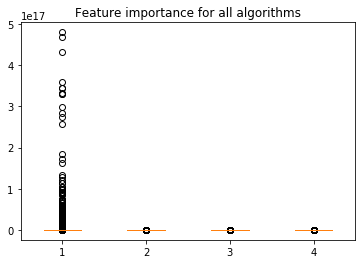

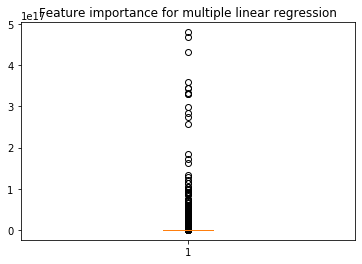

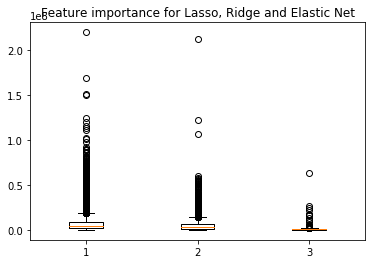

In [83]:
# Boxplot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = [order_lr, order_lasso, order_ridge, order_en]
fig1, ax1 = plt.subplots()
ax1.set_title('Feature importance for all algorithms')
ax1.boxplot(data)
plt.show()

data = [order_lr]
fig1, ax1 = plt.subplots()
ax1.set_title('Feature importance for multiple linear regression')
ax1.boxplot(data)
plt.show()

data = [order_lasso, order_ridge, order_en]
fig1, ax1 = plt.subplots()
ax1.set_title('Feature importance for Lasso, Ridge and Elastic Net')
ax1.boxplot(data)
plt.show()



In [ ]:
#learning a model by using polynomial regression degree=2
from sklearn.preprocessing import PolynomialFeatures

#for 2 options we have: 𝑓(𝑥₁, 𝑥₂) = 𝑏₀ + 𝑏₁𝑥₁ + 𝑏₂𝑥₂ + 𝑏₃𝑥₁² + 𝑏₄𝑥₁𝑥₂ + 𝑏₅𝑥₂²
x_train_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_train)
x_train_[:5]


In [ ]:
#len(x_train_.columns)
len(x_train_[0])

In [ ]:
model = LinearRegression().fit(x_train_, y_train)

r_sq = model.score(x_train_, y_train)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

#validation
x_test_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x_test)
y_pred = model.predict(x_test_)

dfErrors = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred, "error":(y_pred - y_test).abs(), "% error":((y_pred - y_test)/y_test).abs()*100})
dfErrors["% error"].describe()
